# Projeto de uma SVM para tarefa de classificação.
Para o Exercício de Fixação de Conceitos 3, foi proposta a elaboração de uma Support Vector Machine (SVM) para realizar a tarefa de classificação binária. O conjunto de dados fornecido já foi separado em treino, teste e validação. Os dados são rotulados e o problema é supervisionado.

In [1]:
import pandas as pd
from sklearn.svm import SVC
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

In [2]:
# ignore pandas warnings for inplace DataFrame substitution
warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
# Adjust figure size
plt.rcParams['figure.figsize'] = (15, 10) 

### Ingestão dos dados
Os dados estão no formato `.mat` e por isso deverão passar por um processamento para facilitar a execução de tarefas posteriores.

In [4]:
# Load dataset
data_train = loadmat('../data/dados_treinamento.mat')
data_val = loadmat('../data/dados_val.mat')
data_tst = loadmat('../data/dados_teste.mat')

### Funções de interesse
Funções utilizadas durante o processo estão concentradas na célula abaixo. 

In [5]:
def convert2pandas(data):
    # Rename columns
    try:
        data['X'] = data['Xval']
        data['y'] = data['yval']
        del data['Xval']
        del data['yval']
    except:
        pass
    try:
        data['X'] = data['Xt']
        data['y'] = data['yt']
        del data['Xt']
        del data['yt']
        
    except:
        pass
    
    # add to pandas dataset 
    df = pd.DataFrame()
    df = pd.DataFrame({
        'x1': data['X'][:,0],
        'x2': data['X'][:,1],
        'y' : data['y'][:,0]
    })
    return df

def plot_data(df):
        
    sns.scatterplot(x='x1',
                y='x2',
                data=df,
                hue="y",
                palette='Accent_r'
                );
    
def plot_result(d_tst, d_tst_pred):
    
    d_tst_y = d_tst['y']
    
    
    tp = (d_tst_y.values.reshape(1000,) == 1) & (d_tst_pred['y'].values.reshape(1000,) == 1)
    tn = (d_tst_y.values.reshape(1000,) == -1) & (d_tst_pred['y'].values.reshape(1000,) == -1)
    fp = (d_tst_y.values.reshape(1000,) == -1) & (d_tst_pred['y'].values.reshape(1000,) == 1)
    fn = (d_tst_y.values.reshape(1000,) == 1) & (d_tst_pred['y'].values.reshape(1000,) == -1)

    plt.scatter(x = d_tst['x1'][tp], y = d_tst['x2'][tp],  c='blue', marker='o',alpha=0.2, edgecolors='none', s=30);
    plt.scatter(x = d_tst['x1'][tn], y = d_tst['x2'][tn],  c='red', marker='o',alpha=0.2, edgecolors='none', s=30);
    plt.scatter(x = d_tst['x1'][fp], y = d_tst['x2'][fp],  c='red', marker='x',alpha=0.8, edgecolors='none', s=30);
    plt.scatter(x = d_tst['x1'][fn], y = d_tst['x2'][fn],  c='blue', marker='x',alpha=0.8, edgecolors='none', s=30);
    plt.xlim([-2.5,2.5]);
    plt.ylim([-2.5,2.5]);
    
def plot_data_scatter(ax, df):
    color= ['red' if l == -1 else 'green' for l in df['y']]
    ax.scatter(x = df['x1'], y = df['x2'], label=df['y'], alpha=0.8, c=color, edgecolors='none', s=30)

def accuracy(df, df_pred):
    p, f = 0, 0
    for idx in range(len(df)):
        if(df['y'][idx] == df_pred['y'][idx]):
            p += 1
        else:
            f += 1
    return p/len(df) * 100

In [6]:
# split dataset
d_train = convert2pandas(data_train)
d_train_x = d_train.loc[:, ['x1','x2']]
d_train_y = d_train.loc[:, ['y']]

d_val = convert2pandas(data_val)
d_val_x = d_val.loc[:, ['x1','x2']]
d_val_y = d_val.loc[:, ['y']]

d_tst = convert2pandas(data_tst)
d_tst_x = d_tst.loc[:, ['x1','x2']]
d_tst_y = d_tst.loc[:, ['y']]

### Visualização dos dados
A figura abaixo mostra o conjunto de treino e seus respectivos rótulos. A classe C+ é representada pelos pontos +1 ,que estão em verde, e a classe C- é representada pelos pontos -1, que estão em cinza. Pode-se notar que os dados **não** são fácilmente separáveis por uma única reta, o que sugere que algoritmos não lineares devem ter maior eficiência para classificar os dados.

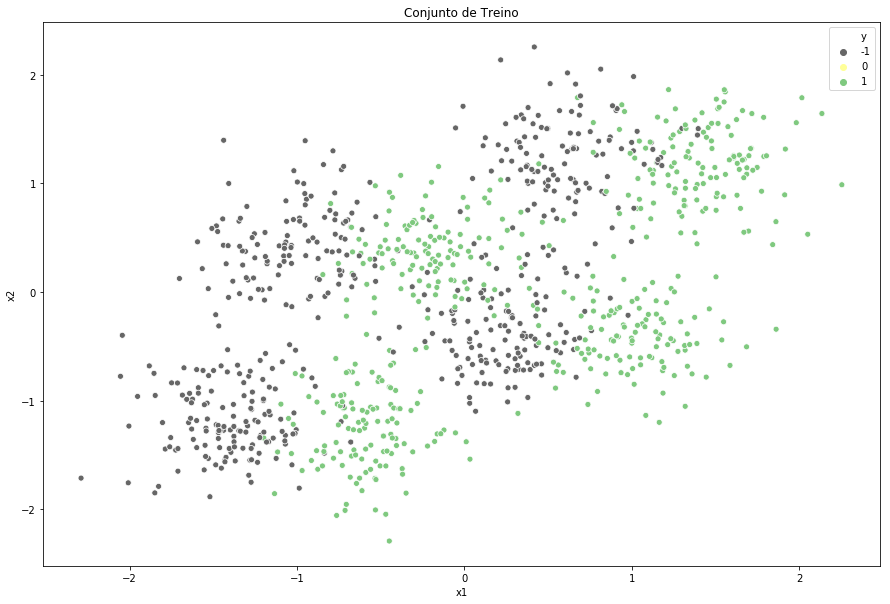

In [7]:
plot_data(d_train)
plt.title("Conjunto de Treino")
plt.show()

### Treinando o modelo SVM
Para essa primeira parte do projeto, utilizaremos os valores padrão do classificador de SVM, o SVC (SVM Classifier) do pacote Sci-kit Learn. Nessa primeira abordagem:
* **Kernel**: o kernel utilizado é o gaussiano. Na documentação o nome do kernel é $\it{Radial Basis Function}$ ou rbf. O kernel gaussiano é um caso particular do kernel rbf, o qual pode ser escrito da seguinte forma:
$$\Phi(x - x') = e^{-\gamma(x-x')^2}$$

* **Regularização**: o hiperparâmetro de regularização C = 1
* **Gamma**: hiperparâmetro do kernel gaussiano gamma='auto', que é o padrão para a versão do SKLearn que estamos usando e corresponde a 1/num_de_features.

In [8]:
# instantiate the classifier model
clf = SVC(C=1, kernel='rbf', gamma='auto')

# train the model
clf.fit(d_train_x, d_train_y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Classificador junto ao aos dados
Na figura que segue, pode-se visualizar as duas regiões de classificação encontradas pelo classificador SVM utilizando kernel gaussiano. Para gerar essa visualização, foi utilizado um meshgrid.

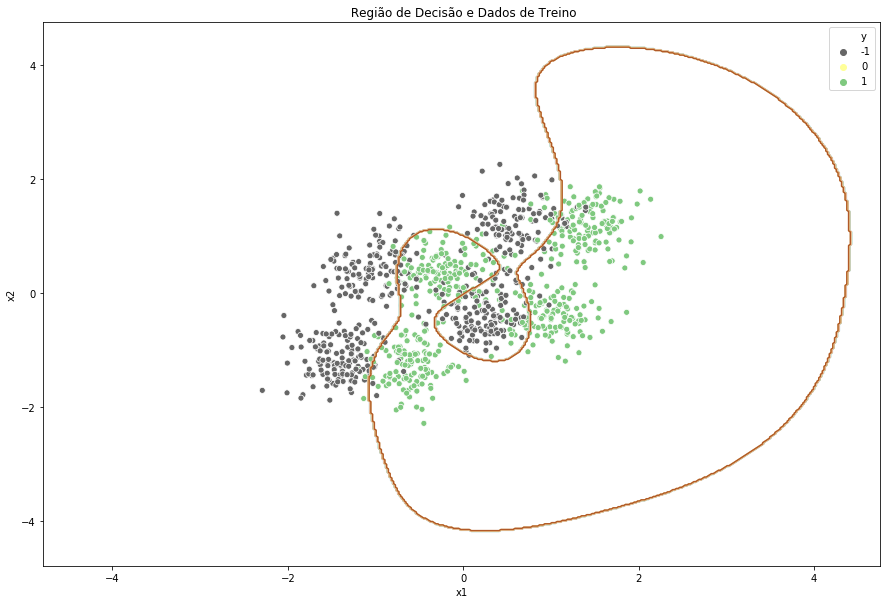

In [9]:
h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = d_train_x['x1'].min() - 2.5 , d_train_x['x1'].max() + 2.5
y_min, y_max = d_train_x['x2'].min() - 2.5, d_train_x['x2'].max()  + 2.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
plot_data(d_train)
plt.title(" Região de Decisão e Dados de Treino")
plt.show()

A figura acima mostra que a SVM com kernel gaussiano possui um grau de flexibilidade que é interessante para o propósito do problema, dado que a curva de separação consegue se contorcer para se adequar ao conjunto de dados rotulados.

### Vetores suporte
A formulação do problema de classificação através de SVM é feita de modo que apenas os vetores que definem a borda das regiões de decisão constituem a região de decisão entre as duas classes. Na figura abaixo, demonstra-se os vetores suportes em verde, juntamente com os dados classificados como -1 em cinza e como +1 em amarelo.

In [10]:
# acquire supporting vectors
sv = clf.support_vectors_
# label the supporting vector as 2
sv_df = pd.DataFrame({
    'x1': sv[:,0],
    'x2': sv[:,1]
})
sv_df['y'] = 2
# append the supporting vectors to plot all data once
d_train = d_train.append(sv_df)

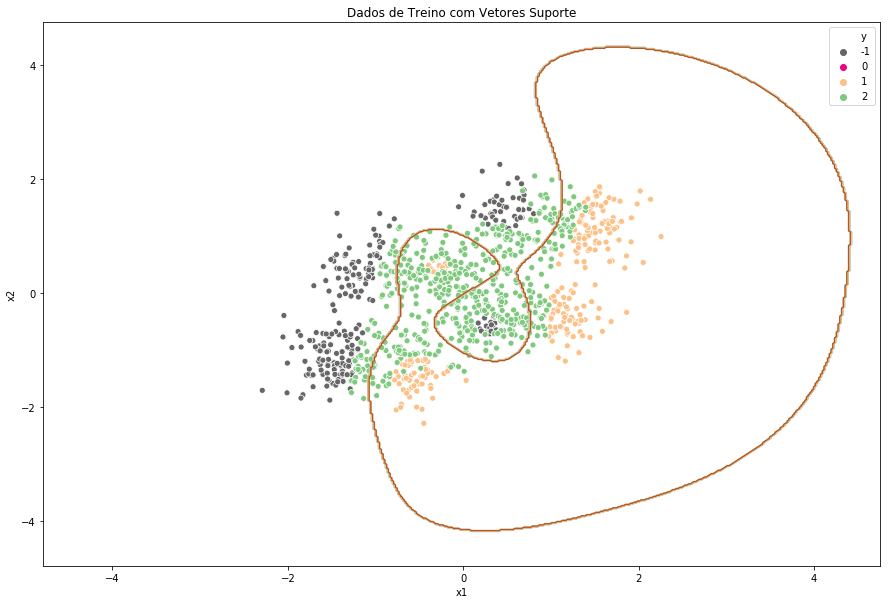

In [11]:
plot_data(d_train)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
plt.title("Dados de Treino com Vetores Suporte")
plt.show()

### Dados de teste em uma SVM
Após treinar a SVM com dados de treino, deve-se aplicar um conjunto de testes para fazer a validação cruzada do modelo.

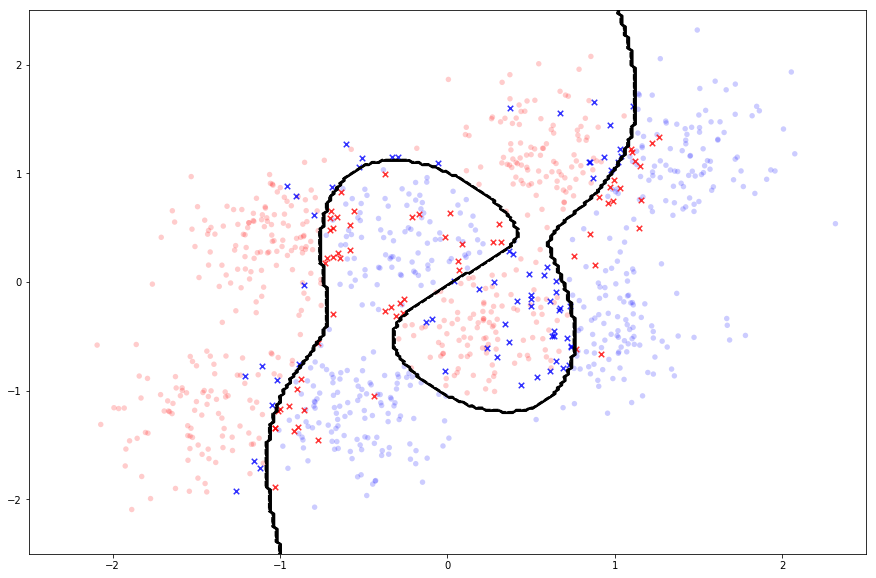

In [12]:
d_tst_pred = d_tst_x
# predict test set and set to column y
d_tst_pred['y'] = clf.predict(d_tst_x)
color = ['red' if l == 2 else 'gray' for l in d_tst_y['y']]
plt.contour(xx, yy, Z, colors='black')
plot_result(d_tst, d_tst_pred)

A figura acima mostra o conjunto de teste após a etapa de predição utilizando o modelo previamente treinado. As observações em formato de círculo e mais opacas constituem os dados que foram classificados da maneira correta de acordo com seus rótulos. Já as observações com formato de xis foram os dados classificados erroneamente. Pode-se notar que esses dados que foram classificados de maneira errada de fato representam os pontos que estão espalhados em regiões de decisão que não são compatíveis aos seus rótulos. Isso demonstra o quanto a SVM é robusta para detecção de outliars.  

In [13]:
print ("Acurácia : " + str(accuracy(d_tst, d_tst_pred)) + "%")

Acurácia : 86.6%


A acurácia desse modelo aplicado ao conjunto de testes foi de 86.6%  utilizando os parâmetros `C = 1`, e kernel gaussiano.

### Modificações em hiperparâmetros
Nessa etapa serão feitas algumas modificações nos modelos a fim de verificar qual o comportamento atingido. Serão usados valores diferentes para o fator de regularização C e os tipos de função kernel existentes no pacote utilizado.

#### Fator C de regularização
A primeira abordagem foi de manter o kernel gaussiano e de variar o hiperparâmetro C que corresponde ao fator de regularização. 

Acurácia C = 0.01: 62.1%


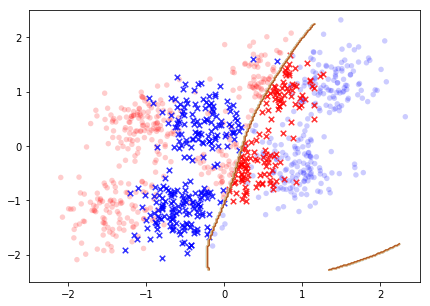

Acurácia C = 0.1: 72.3%


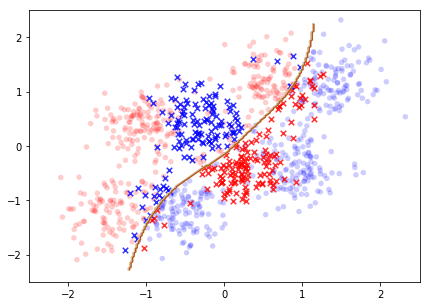

Acurácia C = 1: 86.6%


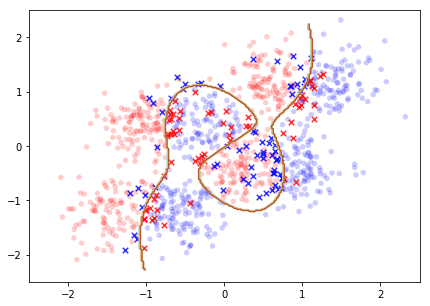

Acurácia C = 10: 87.4%


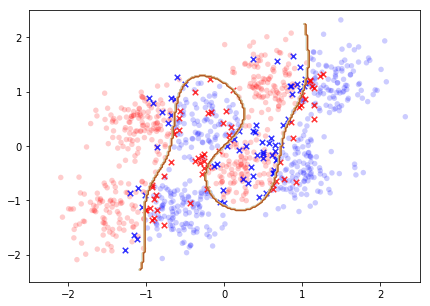

Acurácia C = 100: 87.5%


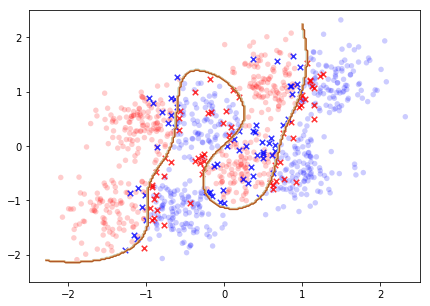

Acurácia C = 1000: 87.4%


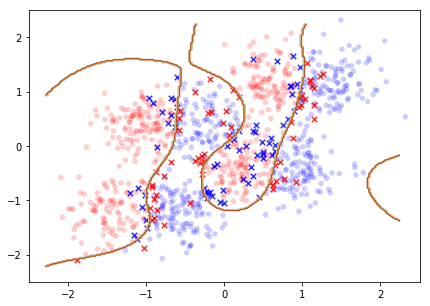

Acurácia C = 10000: 87.4%


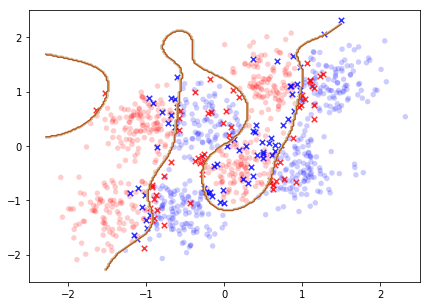

In [14]:

# instantiate the classifier
plt.rcParams['figure.figsize'] = (7, 5)
#Cx =  np.linspace(0.1, 100000, num=11)
Cx = [0.01, 0.1, 1, 10, 100, 1000, 10000]
acc = []
for c in Cx:
    
    clf = SVC(C=c, kernel='rbf', gamma='auto')
    # train the model
    clf.fit(d_train_x, d_train_y)
    # predict test set and set to column y
    d_pred = d_tst_x
    d_pred['y'] = clf.predict(d_tst_x.loc[:,['x1','x2']])
    
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = d_train_x['x1'].min() , d_train_x['x1'].max()
    y_min, y_max = d_train_x['x2'].min() , d_train_x['x2'].max() 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    acc.append(accuracy(d_tst, d_pred))
    print ("Acurácia C = "+ str(c) +": "+ str(accuracy(d_tst, d_pred)) + "%")
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plot_result(d_tst, d_tst_pred)
    plt.show()

Os resultados observados demonstram que a alteração do fator de regularização C melhora um pouco a acurácia do modelo. No entanto, pela forma com a qual a região de decisão ganha flexibilidade aparenta-se que o modelo pode aumentar o sobreajuste a medida que o fator C aumenta pois a região de decisão tenta se ajustar cada vez mais aos dados de treino.

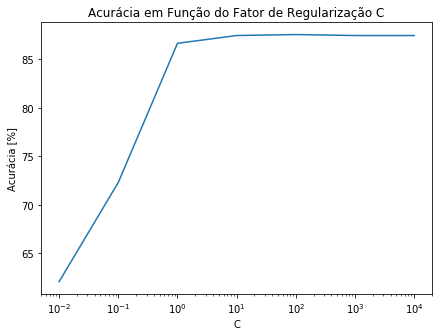

In [17]:
plt.plot(Cx, acc)
plt.xscale('log')
plt.title("Acurácia em Função do Fator de Regularização C")
plt.xlabel('C')
plt.ylabel('Acurácia [%]')
plt.show()

#### Função Kernel
Após variar o parâmetro C, pode-se alterar as funções kernel utilizadas para a SVM. No caso do pacote que foi utilizado, são 4 as principais: **rbf**, **linear**, **poly**, **sigmoid**. Abaixo seguem as figuras dos dados de treino juntamente com as regiões de decisão para cada função kernel. 

Acurácia rbf : 86.6%


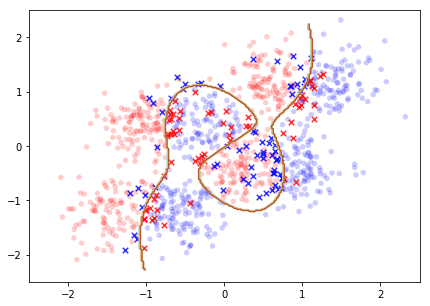

Acurácia linear : 66.60000000000001%


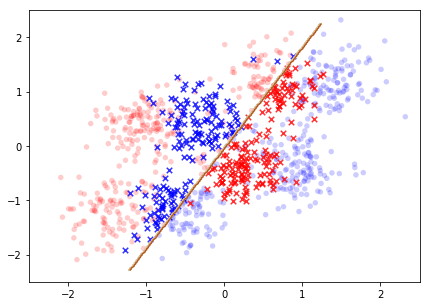

Acurácia poly : 75.1%


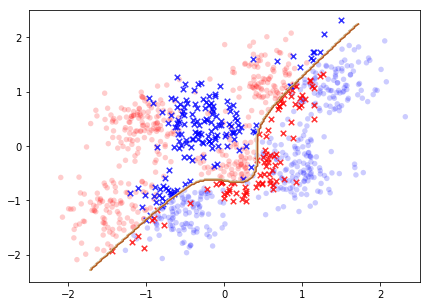

Acurácia sigmoid : 41.9%


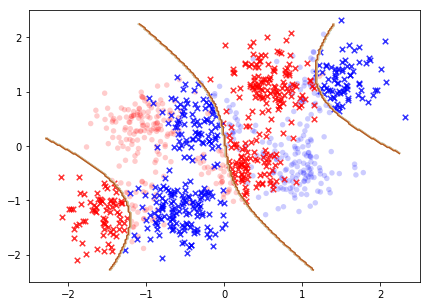

In [18]:
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
for kernel in kernels:
    
    clf = SVC(C=1.0, kernel=kernel, gamma='auto')
    # train the model
    clf.fit(d_train_x, d_train_y)
    # predict test set and set to column y
    d_pred = d_tst_x
    d_pred['y'] = clf.predict(d_tst_x.loc[:,['x1','x2']])
    
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = d_train_x['x1'].min() , d_train_x['x1'].max()
    y_min, y_max = d_train_x['x2'].min() , d_train_x['x2'].max() 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    print ("Acurácia "+ kernel +" : " + str(accuracy(d_tst, d_pred)) + "%")
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plot_result(d_tst, d_tst_pred)
    plt.show()

A partir das figuras exibidas acima pode-se notar que o kernel gaussiano é o que atinge maior acurácia `86.6%`.

Além disso, para cada função kernel existem diversos parâmetros que podem ser ajustados a fim de melhorar o resultado. Por exemplo, o kernel gaussiano possui um termo `gamma`, que já foi explicado no início desse notebook. Já o kernel polinomial leva em consideração um fator `degree` para dimensionar o grau do polinômio e assim sucessivamente. No entanto, para a finalidade do EFC3, não vamos explorar cada parâmetro desse separadamente e exaustivamente pois, para obter melhor resultado, deveríamos treinar o modelo com todas as possibilidades para todos os parâmetros e esse não é o intuito do projeto.